# Population density and COVID-19 mortality
Carl Higgs, Deepti Adlakha, Jim Sallis; 9 August 2022


In [1]:
import pandas as pd

# Preliminary sampling for tertiles of population density


1. Identify the 100 largest urban centres in each region
2. Create tertiles of population density in each region
3. Randomly sample 5 cities  (or as per original suggestion, use the top 5-most dense)
4. Locate COVID-19 mortality data for these cities, where available; else, re-draw a new sample from the relevant continent-specific density tertile
5. Create a scatterplot of results

In the below the following data from the Global Human Settlements Urban Centres Database are retained:

Variable  | Description
----------|------------
GRGN_L1   | Major Geographical Region (UNDESA, 2018b), according to the classification of the main country
CTR_MN_ISO| The ISO 3 code of the main country, i.e., the country within which borders the majority of the area of the Urban Centre is located
CTR_MN_NM | The name of the main country, i.e., the country within which borders the majority of the area of the Urban Centre is located
UC_NM_MN  | The main name of the Urban Centre (the country ISO 3 is declared within ‘[]’, to support the cross border entities);
AREA      | Area in square kilometres
B15       | Total built-up area in 2015 calculated within the spatial domain of the Urban Centre of 2015, expressed in square kilometres
P15       | Total resident population in 2015

In [2]:
# Get the GHS UCDB data
# zip file including multiple formats from
# https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_STAT_UCDB2015MT_GLOBE_R2019A/V1-2/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.zip
df = pd.read_csv('./GHS/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.csv')
covariates = ['GRGN_L1','CTR_MN_NM','UC_NM_MN','AREA','B15','P15']
df = df[covariates]

# only analyse named urban centres (because some small ones in Oceania in particular are not named)
# and set a minimum area of at least 10 square kilometres to mitigate extreme densities 
# for smaller, low population settlements
df = df.loc[(df['UC_NM_MN'].isna()==False) & (df['AREA']>20)]

# calculate population per sqkm in 2015
# using B15, built up area, as more closely matches values eg for Dhaka in Adlakha et al 2020 paper
# however, it is still lower (eg Dhaka approximately 28k instead of 45k)
# difference no doubt largely because targetting a time point 5 years earlier
df['population_density_2015'] = df['P15']/df['B15']
# for display purposes, make population estimate an integer
df['P15'] = df['P15'].astype('int')

df

,GRGN_L1,CTR_MN_NM,UC_NM_MN,AREA,B15,P15,population_density_2015
0,Northern America,United States,Honolulu,185,80.647377,512853,6359.210748
1,Oceania,French Polynesia,Papeete,42,14.493433,91521,6314.661586
2,Northern America,United States,Santa Maria,55,42.000805,123181,2932.831529
3,Northern America,United States,Monterey,48,27.759470,67772,2441.411486
4,Northern America,United States,Santa Barbara,60,38.101749,114753,3011.755416
...,...,...,...,...,...,...,...
13129,Oceania,New Zealand,Hillcrest,115,56.726643,219043,3861.378420
13130,Oceania,New Zealand,Tauranga,70,31.697439,84583,2668.471856
13132,Oceania,Solomon Islands,Honiara,23,4.069641,73669,18102.255748
13133,Oceania,New Caledonia,Nouméa,27,12.111768,70631,5831.666991


In [3]:
# Identify the 100 largest urban centres in each region
selected = df.groupby('GRGN_L1')\
  .apply(lambda x : x.sort_values(by = 'AREA', ascending = False)\
                    .head(100)).reset_index(drop = True)

In [4]:
# all regions have 100 records, except for Oceania, which has 6
selected.groupby('GRGN_L1')['UC_NM_MN'].count()

GRGN_L1
Africa                             100
Asia                               100
Europe                             100
Latin America and the Caribbean    100
Northern America                   100
Oceania                             40
Name: UC_NM_MN, dtype: int64

In [5]:
# Create region specific tertiles of population density for the 100 largest cities in each region which were identified
selected['region_density_tertile'] = selected.groupby(['GRGN_L1'])['population_density_2015'].transform(
                     lambda x: pd.qcut(x, 3, labels=['Q1','Q2','Q3'])
)
selected

,GRGN_L1,CTR_MN_NM,UC_NM_MN,AREA,B15,P15,population_density_2015,region_density_tertile
0,Africa,South Africa,Johannesburg,1638,900.362427,6516134,7237.234741,Q1
1,Africa,Egypt,Cairo,1585,637.769348,19734085,30942.355237,Q3
2,Africa,Nigeria,Lagos,1196,813.717163,11575042,14224.896629,Q2
3,Africa,Ghana,Accra,846,494.896210,4412617,8916.248266,Q1
4,Africa,Nigeria,Onitsha,781,261.669800,3150801,12041.136163,Q1
...,...,...,...,...,...,...,...,...
535,Oceania,Australia,River Glen Village,32,16.558352,56992,3441.911782,Q2
536,Oceania,Australia,Lindum,28,16.999882,53260,3132.995184,Q2
537,Oceania,New Caledonia,Nouméa,27,12.111768,70631,5831.666991,Q3
538,Oceania,New Zealand,Palmerston North,25,14.775366,51492,3485.018617,Q3


In [6]:
# Sample 5 cities from each region specific tertile
#sdf = df.groupby(['GRGN_L1','region_density_tertile']).sample(3,random_state=20220809)

# Top 3
# NOTE: this approach excludes cities on islands in Oceania other than Australia and NZ
# the benefit of this is some smaller cities like Madang and Kokopo in PNG have ridiculously high density estimates
# approaching 60,000 persons per sqkm.
sample = selected.groupby(['GRGN_L1','region_density_tertile']).head(3).sort_values(['GRGN_L1','region_density_tertile'])
sample

,GRGN_L1,CTR_MN_NM,UC_NM_MN,AREA,B15,P15,population_density_2015,region_density_tertile
0,Africa,South Africa,Johannesburg,1638,900.362427,6516134,7237.234741,Q1
3,Africa,Ghana,Accra,846,494.896210,4412617,8916.248266,Q1
4,Africa,Nigeria,Onitsha,781,261.669800,3150801,12041.136163,Q1
2,Africa,Nigeria,Lagos,1196,813.717163,11575042,14224.896629,Q2
5,Africa,Angola,Luanda,771,463.673126,6786991,14637.447828,Q2
6,Africa,Sudan,Khartoum,750,264.521667,5824720,22019.825176,Q2
1,Africa,Egypt,Cairo,1585,637.769348,19734085,30942.355237,Q3
13,Africa,Nigeria,Amaigbo,510,61.440853,1713470,27888.133139,Q3
23,Africa,Morocco,Casablanca,393,157.085449,3985659,25372.557616,Q3
101,Asia,Japan,Tokyo,5318,3664.912354,33028731,9012.147641,Q1


The above is a test run of the discussed sampling method.  There are some awkward aspects, in particular setting a minimum area.  The selection of top 3 vs random 3 cities within regional density tertiles is important --- top3 more or less excludes cities on small islands of Oceania (although linkage with Covid data for these could be problematic, so could be useful). 

Notwithstanding the above -- it is a selection of cities which may now be linked with Covid mortality data, and potentially custom updating of the density statistics.

Once we have Covid mortality data linked, the below are example sketches of how the scatterplots could be produced (noting the current Y axis of 'AREA' makes no sense -- just a placeholder).

In [7]:
# see the assumptions above with GHS data export, this may not be what you're after either
sample.to_csv('GHS - sampled_city_population_density_tertiles_by_region.csv', encoding='utf-8')

# Covid data linkage

In [8]:
# retrieve manually linked covid records
df = pd.read_csv('./covid-data/covid_deaths_manual_notes.csv',encoding='utf-8')
df

,GRGN_L1,CTR_MN_NM,UC_NM_MN,Cumulative deaths reported due to COVID-19,Notes,Data source,Reported Date
0,Africa,Angola,Luanda,NaN,NaN,NaN,NaN
1,Africa,Egypt,Cairo,NaN,NaN,NaN,NaN
2,Africa,Ghana,Accra,NaN,NaN,NaN,NaN
3,Africa,Morocco,Casablanca,NaN,NaN,NaN,NaN
4,Africa,Nigeria,Amaigbo,NaN,NaN,NaN,NaN
5,Africa,Nigeria,Lagos,771.0,"State; suprisingly small number, however most ...",https://covid19.ncdc.gov.ng/#!,15/08/2022
6,Africa,Nigeria,Onitsha,NaN,NaN,NaN,NaN
7,Africa,South Africa,Johannesburg,22143.0,"""Estimated number of excess natural deaths ......",https://www.samrc.ac.za/reports/report-weekly-...,10/08/2022
8,Africa,Sudan,Khartoum,NaN,NaN,NaN,NaN
9,Asia,Bangladesh,Dhaka,NaN,NaN,NaN,NaN


In [9]:
# restrict to manually linked covid records with data recorded for cumulative deaths
df = df.loc[~(df['Cumulative deaths reported due to COVID-19'].isna())].copy()
df['Cumulative deaths reported due to COVID-19'] = df['Cumulative deaths reported due to COVID-19'].astype(int)
df

,GRGN_L1,CTR_MN_NM,UC_NM_MN,Cumulative deaths reported due to COVID-19,Notes,Data source,Reported Date
5,Africa,Nigeria,Lagos,771,"State; suprisingly small number, however most ...",https://covid19.ncdc.gov.ng/#!,15/08/2022
7,Africa,South Africa,Johannesburg,22143,"""Estimated number of excess natural deaths ......",https://www.samrc.ac.za/reports/report-weekly-...,10/08/2022
10,Asia,China,Guangzhou,8,"JHU has Guangdong province, a broader area wit...",https://github.com/CSSEGISandData/COVID-19/blo...,13/08/2022
11,Asia,China,Shanghai,595,Verified GHS and Shanghai province area on Goo...,https://github.com/CSSEGISandData/COVID-19/blo...,13/08/2022
12,Asia,India,Delhi [New Delhi],26376,This expanse approximates the GHS urban agglom...,https://github.com/CSSEGISandData/COVID-19/blo...,13/08/2022
14,Asia,Indonesia,Jakarta,15304,See latest data point of graph (estimate didn'...,https://www.fast-trackcities.org/data-visualiz...,15/07/2022
15,Asia,Japan,Osaka [Kyoto],6110,Sum of Osaka and Kyoto 5313+797=6110,https://github.com/CSSEGISandData/COVID-19/blo...,13/08/2022
16,Asia,Japan,Tokyo,8700,"Sum of Chiba,",https://github.com/CSSEGISandData/COVID-19/blo...,13/08/2022
17,Asia,Thailand,Bangkok,7974,NaN,https://www.fast-trackcities.org/data-visualiz...,16/07/2022
18,Europe,France,Paris,6119,"""According to the latest report as of Tuesday ...",https://www.sortiraparis.com/news/coronavirus/...,17/08/2022


In [10]:
linked = sample.merge(df, how='left', on=['GRGN_L1','CTR_MN_NM','UC_NM_MN'])
linked

,GRGN_L1,CTR_MN_NM,UC_NM_MN,AREA,B15,P15,population_density_2015,region_density_tertile,Cumulative deaths reported due to COVID-19,Notes,Data source,Reported Date
0,Africa,South Africa,Johannesburg,1638,900.362427,6516134,7237.234741,Q1,22143.0,"""Estimated number of excess natural deaths ......",https://www.samrc.ac.za/reports/report-weekly-...,10/08/2022
1,Africa,Ghana,Accra,846,494.896210,4412617,8916.248266,Q1,NaN,NaN,NaN,NaN
2,Africa,Nigeria,Onitsha,781,261.669800,3150801,12041.136163,Q1,NaN,NaN,NaN,NaN
3,Africa,Nigeria,Lagos,1196,813.717163,11575042,14224.896629,Q2,771.0,"State; suprisingly small number, however most ...",https://covid19.ncdc.gov.ng/#!,15/08/2022
4,Africa,Angola,Luanda,771,463.673126,6786991,14637.447828,Q2,NaN,NaN,NaN,NaN
5,Africa,Sudan,Khartoum,750,264.521667,5824720,22019.825176,Q2,NaN,NaN,NaN,NaN
6,Africa,Egypt,Cairo,1585,637.769348,19734085,30942.355237,Q3,NaN,NaN,NaN,NaN
7,Africa,Nigeria,Amaigbo,510,61.440853,1713470,27888.133139,Q3,NaN,NaN,NaN,NaN
8,Africa,Morocco,Casablanca,393,157.085449,3985659,25372.557616,Q3,NaN,NaN,NaN,NaN
9,Asia,Japan,Tokyo,5318,3664.912354,33028731,9012.147641,Q1,8700.0,"Sum of Chiba,",https://github.com/CSSEGISandData/COVID-19/blo...,13/08/2022


In [11]:
linked.groupby('GRGN_L1')[['P15','B15','population_density_2015','Cumulative deaths reported due to COVID-19']].describe().astype(int).transpose()

GRGN_L1                                             Africa      Asia  \
P15                                        count         9         9   
                                           mean    7077724  26338694   
                                           std     5514060   8852966   
                                           min     1713470  14730839   
                                           25%     3985659  21620289   
                                           50%     5824720  24472119   
                                           75%     6786991  33028731   
                                           max    19734085  40589878   
B15                                        count         9         9   
                                           mean        450      1876   
                                           std         291       914   
                                           min          61       867   
                                           25%         261      1212   
                                           50%         463      1889   
                                           75%         637      2113   
                                           max         900      3664   
population_density_2015                    count         9         9   
                                           mean      18142     15926   
                                           std        8624      6429   
                                           min        7237      7425   
                                           25%       12041     11619   
                                           50%       14637     14646   
                                           75%       25372     19221   
                                           max       30942     27599   
Cumulative deaths reported due to COVID-19 count         2         7   
                                           mean      11457      9295   
                                           std       15112      9147   
                                           min         771         8   
                                           25%        6114      3352   
                                           50%       11457      7974   
                                           75%       16800     12002   
                                           max       22143     26376   

GRGN_L1                                             Europe  \
P15                                        count         9   
                                           mean    5507146   
                                           std     4433374   
                                           min     1913888   
                                           25%     2426862   
                                           50%     3167668   
                                           75%     9609627   
                                           max    14077364   
B15                                        count         9   
                                           mean        755   
                                           std         372   
                                           min         400   
                                           25%         457   
                                           50%         574   
                                           75%        1157   
                                           max        1294   
population_density_2015                    count         9   
                                           mean       6543   
                                           std        2291   
                                           min        4288   
                                           25%        5308   
                                           50%        5513   
                                           75%        7423   
                                           max       11553   
Cumulative deaths reported due to COVID-19 count         7   
           

In [12]:
linked[['P15','B15','population_density_2015','Cumulative deaths reported due to COVID-19']].describe().astype(int)

,P15,B15,population_density_2015,Cumulative deaths reported due to COVID-19
count,54,54,54,37
mean,9284597,1104,9621,15972
std,9816783,1013,7777,19064
min,198971,56,1546,8
25%,2238304,393,3411,2910
50%,4643168,808,7173,8700
75%,14230630,1344,13985,19102
max,40589878,4632,30942,76368


array([[<AxesSubplot:title={'center':'P15'}>,
        <AxesSubplot:title={'center':'B15'}>],
       [<AxesSubplot:title={'center':'population_density_2015'}>,
        <AxesSubplot:title={'center':'Cumulative deaths reported due to COVID-19'}>]],
      dtype=object)

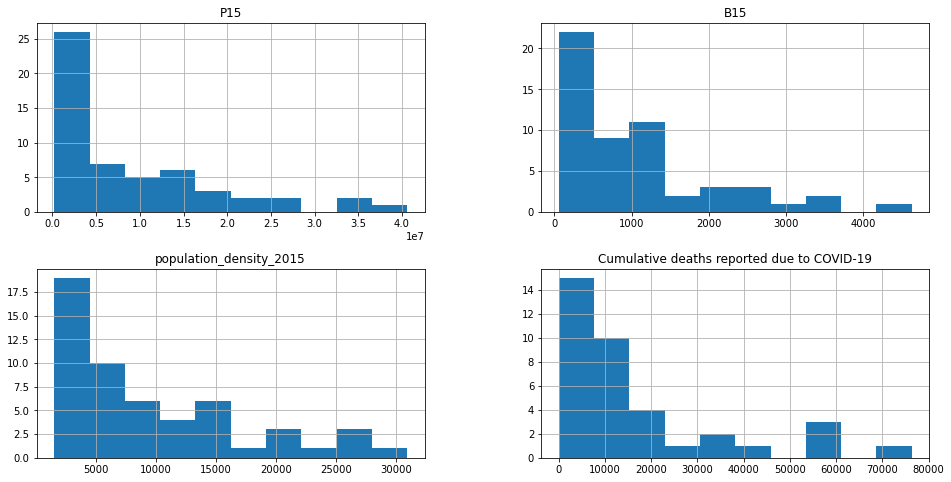

In [13]:
linked[['P15','B15','population_density_2015','Cumulative deaths reported due to COVID-19']].hist(figsize=(16,8))

# Example plots

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# set up for plotting
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
def annotate_points(x,y,t,offset=100,df=None, **kwargs):
    ax = plt.gca()
    if df is None:
        data = kwargs.pop('data')
    else:
        data=df.copy()
    for i,row in data.iterrows():
        ax.annotate(row[t], xy=(row[x]*1.01,row[y]))

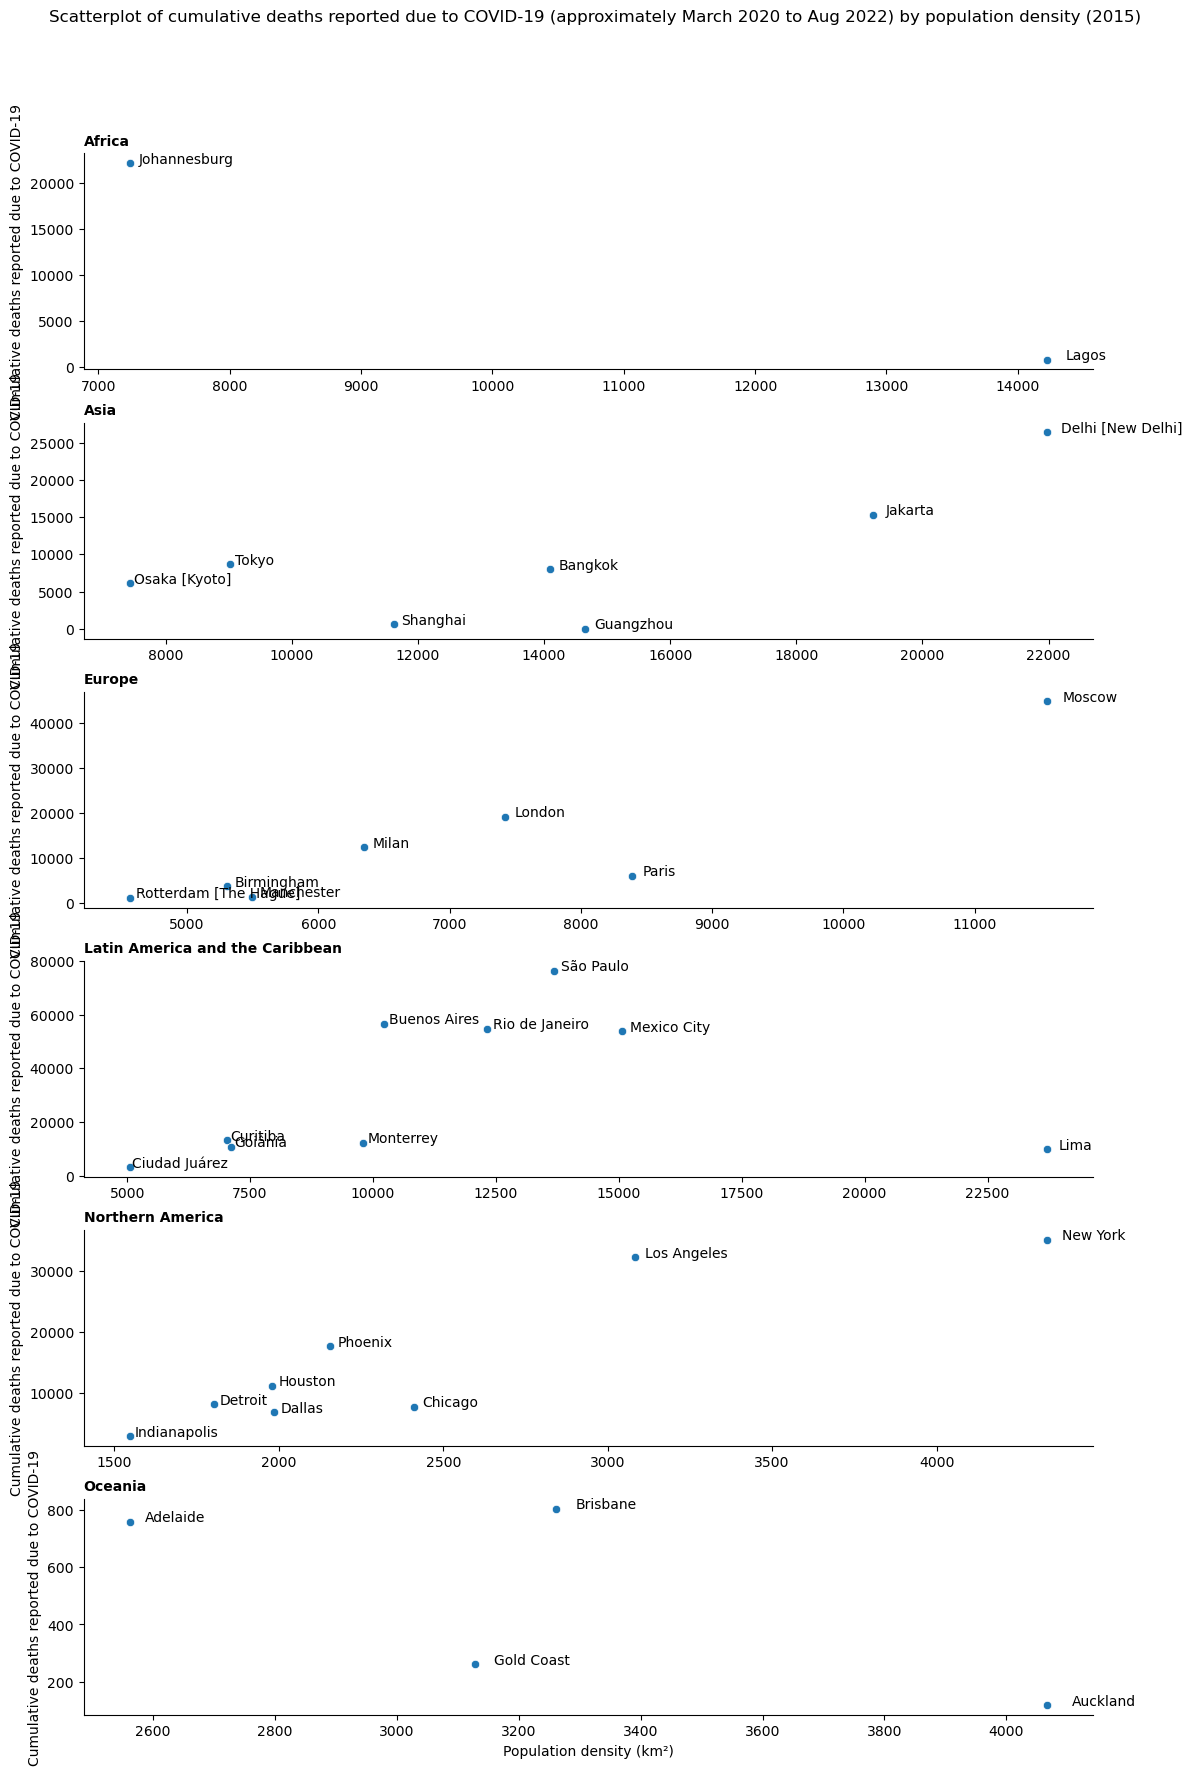

In [15]:


markers=['x','o','^']
        
# scatter plot of y with regard to x by col with levels of hue
g = sns.FacetGrid(linked, col='GRGN_L1',col_wrap=1,aspect=4,
                  #hue='region_density_tertile', 
                  sharex=False,
                 sharey=False)
g.map(sns.scatterplot,'population_density_2015','Cumulative deaths reported due to COVID-19')
#g = sns.lmplot(x="population_density_2015", 
#               y="AREA", 
#               #hue="region_density_tertile", 
#               col="GRGN_L1",
#               data=sdf, 
#               height=3, 
#               aspect=2,
#               col_wrap=1, 
#               sharex=False,
#               sharey=False,
#               legend=True, 
#               #markers=markers,
#               fit_reg=False)

g.map_dataframe(annotate_points,'population_density_2015','Cumulative deaths reported due to COVID-19','UC_NM_MN')
g.set_titles('{col_name}',fontdict= { 'fontsize': 24, 'fontweight':'bold', 'horizontalalignment':'left','x':0})
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Scatterplot of cumulative deaths reported due to COVID-19 (approximately March 2020 to Aug 2022) by population density (2015)')
g.set_axis_labels("Population density (km²)", 'Cumulative deaths reported due to COVID-19')


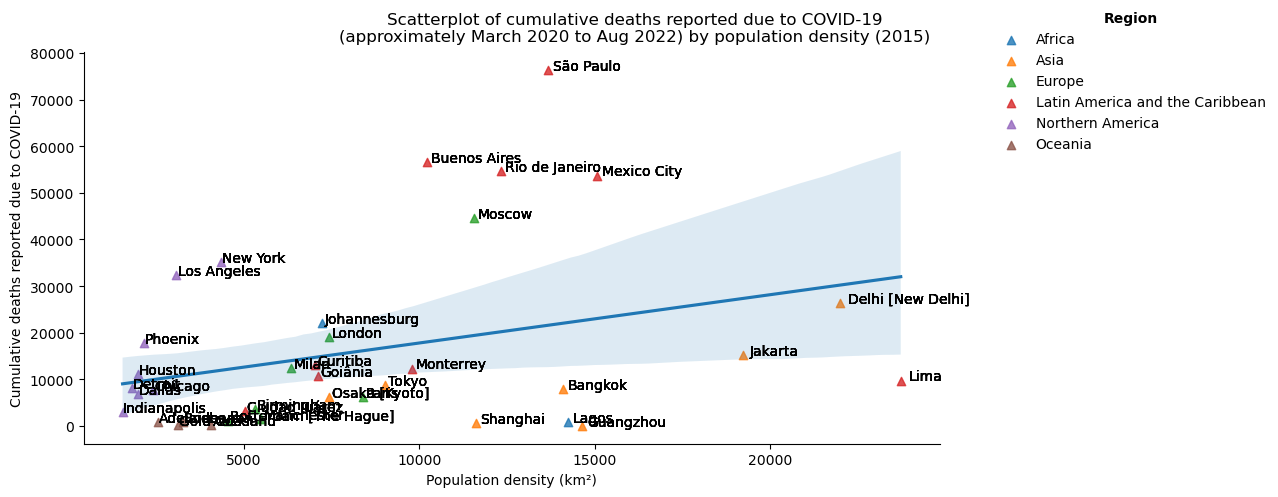

In [16]:
markers=['^']*6
g = sns.lmplot(x="population_density_2015", 
               y='Cumulative deaths reported due to COVID-19', 
               hue="GRGN_L1",
               data=linked, 
               aspect=2,
               legend=True, 
               fit_reg=False,
               logx=True,
               ci=95,
              truncate=True,
              markers=markers)
sns.regplot(x="population_density_2015", 
            y='Cumulative deaths reported due to COVID-19', 
            data=linked, 
            scatter=False, 
            ax=g.axes[0, 0])
g.map_dataframe(annotate_points,'population_density_2015','Cumulative deaths reported due to COVID-19','UC_NM_MN',df=linked.copy())
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Scatterplot of cumulative deaths reported due to COVID-19\n(approximately March 2020 to Aug 2022) by population density (2015)')
g.set_axis_labels("Population density (km²)", 'Cumulative deaths reported due to COVID-19')
g.legend.set_title('Region',prop={'weight':'bold'})
sns.move_legend(g, "upper right")

## not implemented attempt at changing x axis scale
#ticks = [1000,2000,4000,8000,16000]
#g.ax.set_xticks(ticks)
#plt.xscale('log')
#g.ax.set_xticklabels(ticks)


In [ ]:
markers=['^']*6
g = sns.lmplot(x="population_density_2015", 
               y='Cumulative deaths reported due to COVID-19', 
               hue="GRGN_L1",
               col="GRGN_L1",
               data=linked, 
               height=3, 
               aspect=2,
               col_wrap=1,
               legend=True, 
               facet_kws = {'sharex':False,'sharey':False},
               fit_reg=False,
               logx=True,
               ci=95,
              truncate=True,
              markers=markers)
for ax in g.axes.flat:
    sns.regplot(x="population_density_2015", 
                y='Cumulative deaths reported due to COVID-19', 
                data=linked, 
                scatter=False, 
                ax=ax,
               truncate=True)
    
#g.map_dataframe(annotate_points,'population_density_2015','Cumulative deaths reported due to COVID-19','UC_NM_MN',df=linked.copy())
    
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Scatterplot of cumulative deaths reported due to COVID-19\n(approximately March 2020 to Aug 2022) by population density (2015)')
g.set_axis_labels("Population density (km²)", 'Cumulative deaths reported due to COVID-19')
g.set_titles('{col_name}',fontdict= { 'fontsize': 24, 'fontweight':'bold', 'horizontalalignment':'left','x':0})
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp

#g.legend.set_title('Region',prop={'weight':'bold'})    
#sns.move_legend(g, "upper right")

## not implemented attempt at changing x axis scale
#ticks = [1000,2000,4000,8000,16000]
#g.ax.set_xticks(ticks)
#plt.xscale('log')
#g.ax.set_xticklabels(ticks)


[Text(0, 2, '100'),
 Text(0, 3, '1000'),
 Text(0, 4, '10000'),
 Text(0, 5, '100000')]

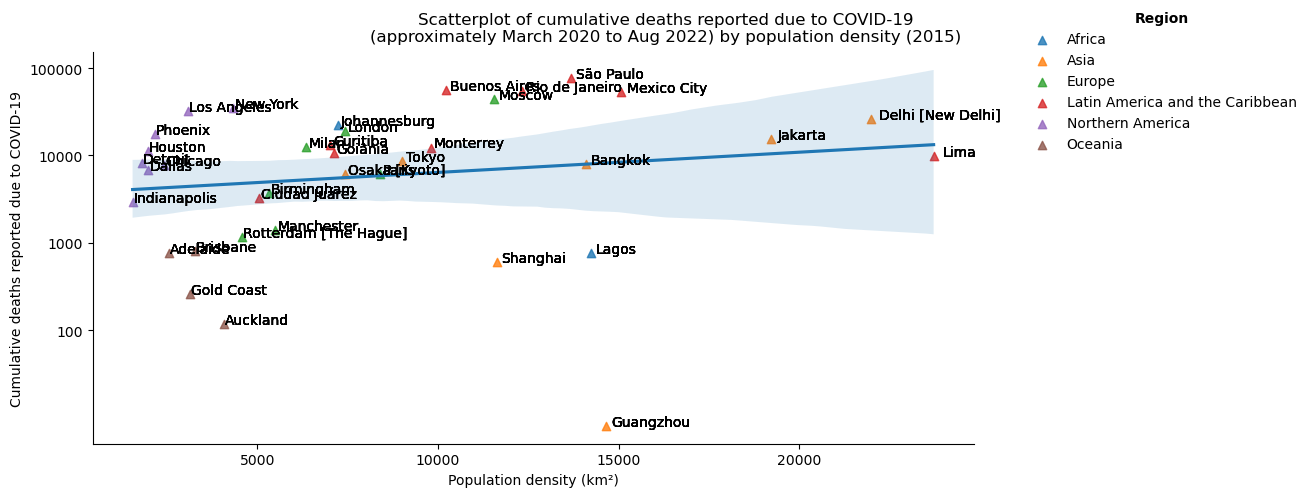

In [30]:
# Plot with linear fit for log10 deaths; displaying exponentiated (ie. 10 to the power x) tick labels
# This will provide a better fit given the skewed data, although it still may not be ideal
import numpy as np
linked['log_deaths'] = np.log10(linked['Cumulative deaths reported due to COVID-19'])
markers=['^']*6


g = sns.lmplot(x='population_density_2015', 
               y='log_deaths', 
               hue="GRGN_L1",
               data=linked, 
               aspect=2,
               legend=True, 
               fit_reg=False,
               ci=95,
              truncate=True,
              markers=markers)
sns.regplot(x="population_density_2015", 
            y='log_deaths', 
            data=linked, 
            scatter=False, 
            ax=g.axes[0, 0])
g.map_dataframe(annotate_points,'population_density_2015','log_deaths','UC_NM_MN',df=linked.copy())
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Scatterplot of cumulative deaths reported due to COVID-19\n(approximately March 2020 to Aug 2022) by population density (2015)')
g.set_axis_labels("Population density (km²)", 'Cumulative deaths reported due to COVID-19')
g.legend.set_title('Region',prop={'weight':'bold'})
sns.move_legend(g, "upper right")

ticks = list(np.arange(2,6,1))
g.ax.set_yticks(ticks)
g.ax.set_yticklabels([10**x for x in ticks])
#g.ax.set_yticks(10**y_labels)
#g.ax.set_yticklabels(y_labels)
